In [19]:
%matplotlib notebook

In [20]:
import numpy as np
import scipy.optimize as sopt
import matplotlib.pyplot as plt
#import pydae.ssa as ssa
#import pydae.grid_tools as gt
import time
import json
import pydae.grid_tools as gt

plt.style.use('easyres.mplstyle')

* Local control LV side (lctrl_lv)
* Local control MV side (lctrl_mv)
* Centralized control: reference tracking (cctrl_ref)
* Centralized control: perturbation rejection (cctrl_pert)
* Centralized control with local in MV side: perturbation rejection (cctrl_mv_pert)
* Distributed control with local in LV side: reference tracking (dctrl_lv_ref)
* Distributed control with local in MV side: reference tracking (dctrl_mv_ref)
* Distributed control with local in LV side: perturbation rejection (dctrl_lv_pert)
* Distributed control with local in MV side: perturbation rejection (dctrl_mv_pert)

In [21]:
from grid_wind_farm import grid_wind_farm_class

In [22]:
syst = grid_wind_farm_class()

In [23]:
syst.initialize([{'v_GRID_c_i':-38105.00*1.00}],'xy_0_dict.json')

True

In [24]:
syst.decimation

10.0

In [52]:
t_0 = time.time()
syst.simulate([{'t_end':0.0,'v_GRID_c_i':-38105.00*1, 'Dt':10e-3,'decimation':1,'T_pq_W1lv':50.0e-3},
               {'t_end':1,  'v_GRID_c_i':-38105.00*1},
               {'t_end':2,  'v_GRID_c_i':-38105.00*0.001,'q_ref_W1lv':100e3,'q_ref_W2lv':100e3 },
               #{'t_end':3,  'v_GRID_c_i':-38105.00*1,'q_ref_W1lv':  0e3,'q_ref_W2lv':  0e3}
              ],'xy_0_dict.json');
print(time.time()-t_0)

1.7250845432281494


<IPython.core.display.Javascript object>


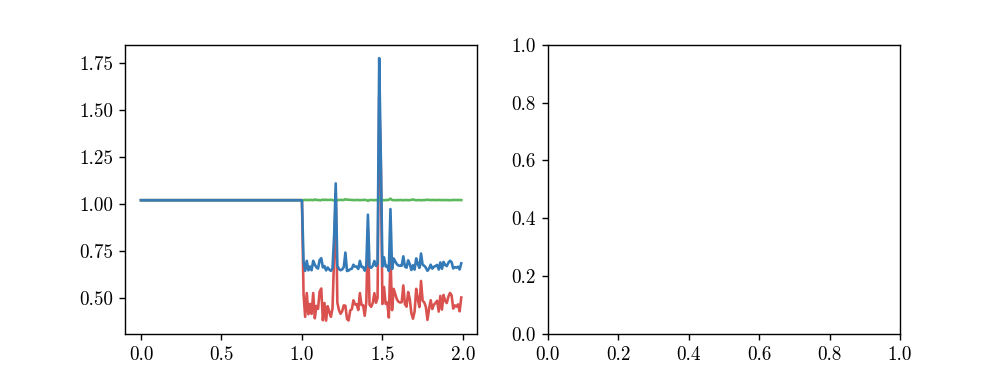

In [53]:
plt.close('all')
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(8, 3), frameon=False, dpi=100, squeeze=False)
V_mv_b = 20e3/np.sqrt(3)
axes[0,0].plot(syst.T, syst.get_values('v_POImv_a_m')/V_mv_b, label="$V_{POI_a}$ (LV)")
axes[0,0].plot(syst.T, syst.get_values('v_POImv_b_m')/V_mv_b, label="$V_{POI_b}$ (LV)")
axes[0,0].plot(syst.T, syst.get_values('v_POImv_c_m')/V_mv_b, label="$V_{POI_c}$ (LV)")

In [54]:
grid_1 = gt.grid(syst)
grid_1.dae2vi()
grid_1.get_v()
grid_1.get_i()

grid_1.bokeh_tools()

gt.plot_results(grid_1)

Figure(id='2992', ...)

In [43]:
Δt = 100.0e-3
Times = np.arange(0,6.0,Δt)

t_0 = time.time()
syst.simulate([{'t_end':0.0,'v_GRID_c_i':-38105.00*1.0, 'Dt':10e-3,'decimation':1,'T_pq_W1lv':50.0e-3}],
               'xy_0_dict.json');


Dq_r_prev = 0.0
for t in Times:
    
    Dq_r = Dq_r_prev
    
    # perturbations and events
    q_ref_W1lv = 0.0
    q_ref_W2lv = 0.0
    q_ref_W3lv = 0.0
    if t >1.0:
        q_ref_W1lv = 100.0e3
        q_ref_W2lv = 100.0e3
        q_ref_W3lv = 100.0e3
    
    # measurments
    
    # control

    
    events = [{'t_end':t,
               'q_ref_W1lv':q_ref_W1lv,'q_ref_W2lv':q_ref_W2lv,'q_ref_W3lv':q_ref_W3lv}]
    syst.run(events)
    
#    U_grid += [U_grid_pu]
#    U += [U_meas_pu]
#    Dq_r_list += [Dq_r]
syst.post();    

print(time.time()-t_0)

0.18356037139892578


<IPython.core.display.Javascript object>


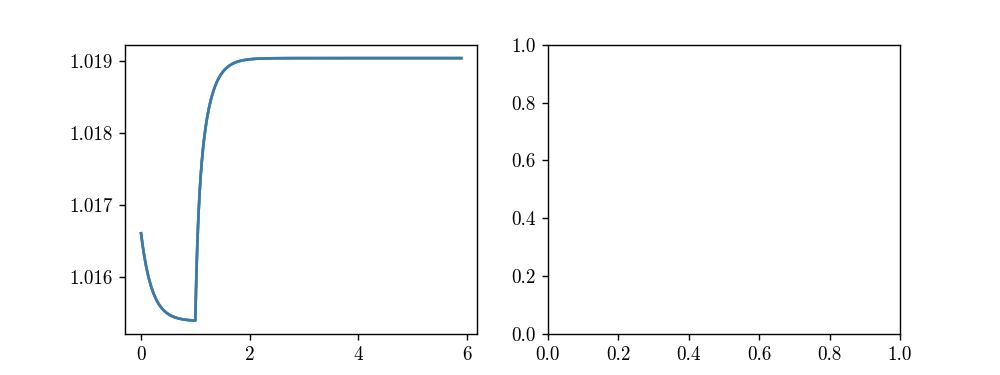

In [44]:
plt.close('all')
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(8, 3), frameon=False, dpi=100, squeeze=False)
V_mv_b = 20e3/np.sqrt(3)
axes[0,0].plot(syst.T, syst.get_values('v_POImv_a_m')/V_mv_b, label="$V_{POI_a}$ (LV)")
axes[0,0].plot(syst.T, syst.get_values('v_POImv_b_m')/V_mv_b, label="$V_{POI_b}$ (LV)")
axes[0,0].plot(syst.T, syst.get_values('v_POImv_c_m')/V_mv_b, label="$V_{POI_c}$ (LV)")

In [10]:
def set_power(grid_obj,bus_name,power):
    '''
    Set new power to a grid feeder.

    Parameters
    ----------
    grid_obj : object of pydgrid.grid class
    bus_name : string
        name of the grid feeder bus.
    power : complex number
        Complex total power to set for the grid former in VA.

    Returns
    -------
    None.

    '''

    greed_feeders_buses = [item['bus'] for item in grid_obj.grid_feeders]
    gfeed_idx = greed_feeders_buses.index(bus_name)
    grid_obj.params_pf[0].gfeed_powers[gfeed_idx,0] = power/3
    grid_obj.params_pf[0].gfeed_powers[gfeed_idx,1] = power/3
    grid_obj.params_pf[0].gfeed_powers[gfeed_idx,2] = power/3
    

def set_voltage(grid_obj,bus_name,voltage,phase):
    '''
    Set new power to a grid feeder.

    Parameters
    ----------
    grid_obj : object of pydgrid.grid class
    bus_name : string
        name of the grid feeder bus.
    voltage : real escalar
        phase-phase RMS voltage magnitude
    phase : real escalar.
        phase angle in degree.

    Returns
    -------
    None.

    '''

 
    v_a = voltage/np.sqrt(3)*np.exp(1j*np.deg2rad(phase))
    v_b = voltage/np.sqrt(3)*np.exp(1j*np.deg2rad(phase-240))
    v_c = voltage/np.sqrt(3)*np.exp(1j*np.deg2rad(phase-120))
    grid_obj.set_value(f'v_{bus_name}_a_r',v_a.real)
    grid_obj.set_value(f'v_{bus_name}_a_i',v_a.imag)
    grid_obj.set_value(f'v_{bus_name}_b_r',v_b.real)
    grid_obj.set_value(f'v_{bus_name}_b_i',v_b.imag)
    grid_obj.set_value(f'v_{bus_name}_c_r',v_c.real)
    grid_obj.set_value(f'v_{bus_name}_c_i',v_c.imag)
    
    
def get_voltage(grid_obj,bus_name):
    '''
    Get voltage module of a bus.

    Parameters
    ----------
    grid_obj : object of pydae class
    bus_name : string
        name of the bus.

    Returns
    -------
    phase-ground voltage module (V).

    '''
    v_a = syst.get_value(f'v_{bus_name}_a_r') + 1j* syst.get_value(f'v_{bus_name}_a_i')
    U_meas = np.abs(v_a) 
    
    return U_meas

def get_flow(grid_obj,bus_j,bus_k,mode='total',model='pydgrid_pydae'):
    if model == 'pydgrid_pydae':
        v_a   = syst.get_values(f'v_{bus_j}_a_r') + 1j* syst.get_values(f'v_{bus_j}_a_i')
        i_l_a = syst.get_values(f'i_l_{bus_j}_{bus_k}_a_r') + 1j* syst.get_values(f'i_l_{bus_j}_{bus_k}_a_i')
        v_b   = syst.get_values(f'v_{bus_j}_b_r') + 1j* syst.get_values(f'v_{bus_j}_b_i')
        i_l_b = syst.get_values(f'i_l_{bus_j}_{bus_k}_b_r') + 1j* syst.get_values(f'i_l_{bus_j}_{bus_k}_b_i')
        v_c   = syst.get_values(f'v_{bus_j}_c_r') + 1j* syst.get_values(f'v_{bus_j}_c_i')
        i_l_c = syst.get_values(f'i_l_{bus_j}_{bus_k}_c_r') + 1j* syst.get_values(f'i_l_{bus_j}_{bus_k}_c_i')
        s_a = v_a*np.conj(i_l_a)
        s_b = v_b*np.conj(i_l_b)
        s_c = v_c*np.conj(i_l_c)

        if mode == 'total':
            s_t = s_a + s_b + s_c
            return s_t
        if mode == 'abc':
            return s_a,s_b,s_c
  

In [56]:
with open('xy_0_dict.json') as json_file:
    data = json.load(json_file)

for item in data:
    if item in syst.x_list:
        syst.struct[0].x[syst.x_list.index(item)] = data[item]
    if item in syst.y_ini_list:
        syst.struct[0].y_ini[syst.y_ini_list.index(item)] = data[item]     
        
xy_0 = np.vstack([syst.struct[0].x,syst.struct[0].y_ini])[:,0]
syst = grid_wind_farm_class()
syst.Dt = 0.001
syst.xy_prev = xy_0


### Local control LV side

In [57]:
syst = grid_wind_farm_class()
syst.Dt = 0.001
syst.decimation = 1
syst.update()
syst.xy_prev = xy_0
K_p_v = 0.01
PV_ctrl = 0
syst.initialization_tol = 1e-8
syst.initialize([{'v_loc_ref_W1lv':1.0,'v_loc_ref_W2lv':1.0,'v_loc_ref_W3lv':1.0,'v_loc_ref_STlv':1.0,
                  'Dv_r_W1lv':0.0,'Dv_r_W2lv':0.0,'Dv_r_W3lv':0.0,'Dv_r_STlv':0.0,
                  'Dq_r_W1lv':0.0,'Dq_r_W2lv':0.0,'Dq_r_W3lv':0.0,'Dq_r_STlv':0.0,
                  'K_p_v_W1lv':K_p_v,'K_p_v_W2lv':K_p_v,'K_p_v_W3lv':K_p_v,'K_p_v_STlv':0.0,
                  'u_ctrl_v_W1lv':PV_ctrl, 'u_ctrl_v_W2lv':PV_ctrl, 'u_ctrl_v_W3lv':PV_ctrl,'u_ctrl_v_STlv':0}],xy0='prev')

p_w1_0 = 2e6
p_w2_0 = 2e6
p_w3_0 = 2e6

p_w1_1 = 2e6
p_w2_1 = 2e6
p_w3_1 = 2e6

t_0 = time.time()
Dv_r = -0.045
Dq_r = 0.0
events = [
    {'t_end':0.1,
     'Dv_r_W1lv':0,'Dv_r_W2lv':0,'Dv_r_W3lv':0,
     'Dq_r_W1lv':0,'Dq_r_W2lv':0,'Dq_r_W3lv':0,
    },
    {'t_end':0.25,
     'Dv_r_W1lv':Dv_r,'Dv_r_W2lv':Dv_r,'Dv_r_W3lv':Dv_r,
     'Dq_r_W1lv':Dq_r,'Dq_r_W2lv':Dq_r,'Dq_r_W3lv':Dq_r,
    },
          ]
syst.run(events)
print(time.time()-t_0)
syst.post();

0.1156458854675293


<IPython.core.display.Javascript object>


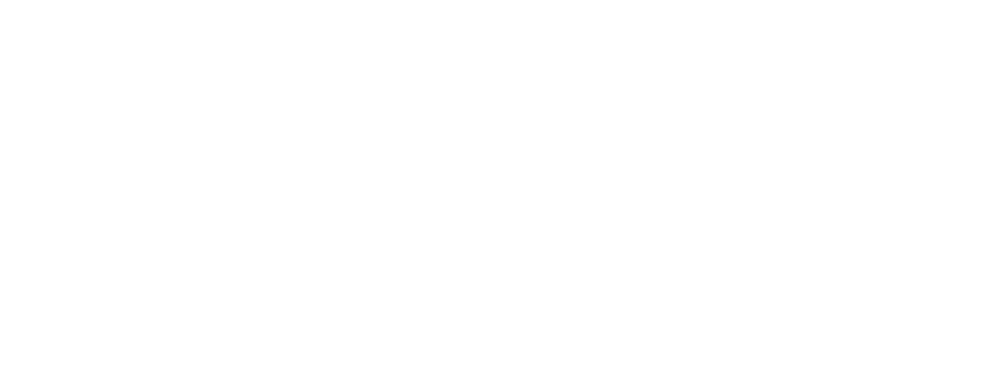

UnboundLocalError: local variable 'values' referenced before assignment

In [9]:
plt.close('all')
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(8, 3), frameon=False, dpi=100, squeeze=False)

v_POI_a = syst.get_values('v_POI_a_r') + 1j* syst.get_values('v_POI_a_i')
v_POI_a_m = np.abs(v_POI_a)/38105

axes[0,0].plot(syst.T, syst.get_values('v_m_W1lv'), label="$V_{W1}$ (LV)")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W2lv'), label=f"W2")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W3lv'), label=f"W3")
axes[0,0].plot(syst.T, syst.get_values('v_m_W1mv'), label="$V_{W1}$ (MV)")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W2mv'), label=f"W2mv")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W3mv'), label=f"W3mv")
axes[0,0].plot(syst.T, v_POI_a_m, label="$V_{POI}$ (HV)")

axes[0,1].plot(syst.T, get_flow(syst,'POI','GRID').real/1e6, label="$P_{POI}$")  
axes[0,1].plot(syst.T, get_flow(syst,'POI','GRID').imag/1e6, label="$Q_{POI}$")  

y_labels = ['Voltages (pu)', 'Powers (MVA)']
for ax,ylabel in zip(axes.flatten(),y_labels):
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.legend()
    ax.set_xlim([0,0.25])

    ax.set_xlabel('Time (s)')

fig.tight_layout()
fig.savefig('lctrl_lv.svg')
fig.savefig('lctrl_lv.png', dpi=200)

### Local control MV side

In [59]:
syst = grid_wind_farm_class()
syst.Dt = 0.001
syst.decimation = 1
syst.update()
syst.xy_prev = xy_0
K_p_v = 0.04
PV_ctrl = 1
syst.initialization_tol = 1e-8
syst.initialize([{'v_loc_ref_W1lv':1.0,'v_loc_ref_W2lv':1.0,'v_loc_ref_W3lv':1.0,'v_loc_ref_STlv':1.0,
                  'Dv_r_W1lv':0.0,'Dv_r_W2lv':0.0,'Dv_r_W3lv':0.0,'Dv_r_STlv':0.0,
                  'Dq_r_W1lv':0.0,'Dq_r_W2lv':0.0,'Dq_r_W3lv':0.0,'Dq_r_STlv':0.0,
                  'K_p_v_W1lv':K_p_v,'K_p_v_W2lv':K_p_v,'K_p_v_W3lv':K_p_v,'K_p_v_STlv':0.0,
                  'u_ctrl_v_W1lv':PV_ctrl, 'u_ctrl_v_W2lv':PV_ctrl, 'u_ctrl_v_W3lv':PV_ctrl,'u_ctrl_v_STlv':0}],xy0='prev')

p_w1_0 = 2e6
p_w2_0 = 2e6
p_w3_0 = 2e6

p_w1_1 = 2e6
p_w2_1 = 2e6
p_w3_1 = 2e6

t_0 = time.time()
Dv_r = -0.02
Dq_r = 0.0
events = [
    {'t_end':0.1,
     'Dv_r_W1lv':0,'Dv_r_W2lv':0,'Dv_r_W3lv':0,
     'Dq_r_W1lv':0,'Dq_r_W2lv':0,'Dq_r_W3lv':0,
    },
    {'t_end':0.25,
     'Dv_r_W1lv':Dv_r,'Dv_r_W2lv':Dv_r,'Dv_r_W3lv':Dv_r,
     'Dq_r_W1lv':Dq_r,'Dq_r_W2lv':Dq_r,'Dq_r_W3lv':Dq_r,
    },
          ]
syst.run(events)
print(time.time()-t_0)
syst.post();

0.11838412284851074


<IPython.core.display.Javascript object>


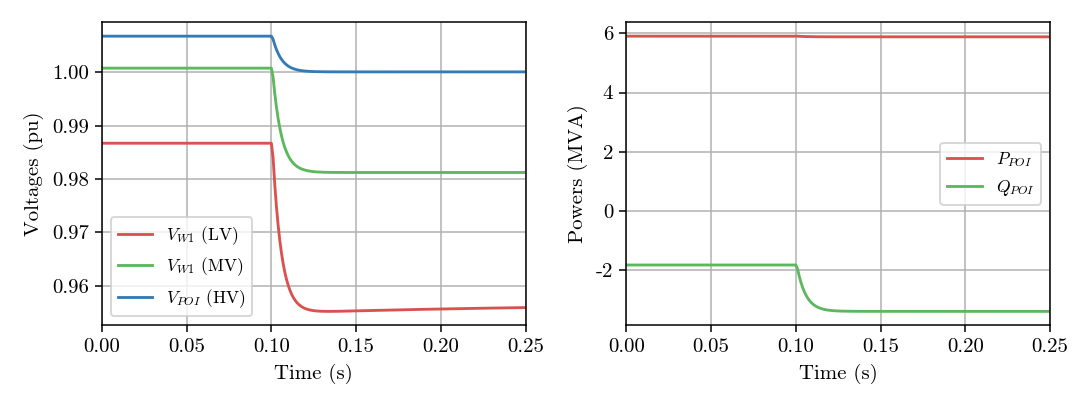

In [60]:
plt.close('all')
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(8, 3), frameon=False, dpi=100, squeeze=False)

v_POI_a = syst.get_values('v_POI_a_r') + 1j* syst.get_values('v_POI_a_i')
v_POI_a_m = np.abs(v_POI_a)/38105

axes[0,0].plot(syst.T, syst.get_values('v_m_W1lv'), label="$V_{W1}$ (LV)")
axes[0,0].plot(syst.T, syst.get_values('v_m_W1mv'), label="$V_{W1}$ (MV)")
axes[0,0].plot(syst.T, v_POI_a_m, label="$V_{POI}$ (HV)")

axes[0,1].plot(syst.T, get_flow(syst,'POI','GRID').real/1e6, label="$P_{POI}$")  
axes[0,1].plot(syst.T, get_flow(syst,'POI','GRID').imag/1e6, label="$Q_{POI}$")  

y_labels = ['Voltages (pu)', 'Powers (MVA)']
for ax,ylabel in zip(axes.flatten(),y_labels):
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.legend()
    ax.set_xlim([0,0.25])

    ax.set_xlabel('Time (s)')

fig.tight_layout()
fig.savefig('lctrl_mv.svg')
fig.savefig('lctrl_mv.png', dpi=200)


### Centralized control tracking

In [66]:
syst = grid_wind_farm_class()
syst.Dt = 0.005
syst.xy_prev = xy_0
syst.update()
K_p_v = 0.01
PV_ctrl = 0
syst.initialization_tol = 1e-8
syst.initialize([{'v_loc_ref_W1lv':1.0,'v_loc_ref_W2lv':1.0,'v_loc_ref_W3lv':1.0,'v_loc_ref_STlv':1.0,
                  'Dv_r_W1lv':0.0,'Dv_r_W2lv':0.0,'Dv_r_W3lv':0.0,'Dv_r_STlv':0.0,
                  'Dq_r_W1lv':0.0,'Dq_r_W2lv':0.0,'Dq_r_W3lv':0.0,'Dq_r_STlv':0.0,
                  'K_p_v_W1lv':K_p_v,'K_p_v_W2lv':K_p_v,'K_p_v_W3lv':K_p_v,'K_p_v_STlv':0.0,
                  'u_ctrl_v_W1lv':PV_ctrl, 'u_ctrl_v_W2lv':PV_ctrl, 'u_ctrl_v_W3lv':PV_ctrl,'u_ctrl_v_STlv':0}],xy0='prev')

p_w1_0 = 2e6
p_w2_0 = 2e6
p_w3_0 = 2e6

p_w1_1 = 2e6
p_w2_1 = 2e6
p_w3_1 = 2e6

Dt = 0.2
Times = np.arange(0,6.0,Dt)
U_ref = 66.0e3
xi = 0

K_p = 0.01
K_i = 0.1
S_base = 1e6
U_base = 66e3

U_grid = []
U = []
Dq_r_list = []
t_0 = time.time()
Dv_r_prev = 0.0
Dq_r_prev = 0.0

for t in Times:
    
    Dv_r = Dv_r_prev
    Dq_r = Dq_r_prev
    
    # perturbations and events
    U_ref_pu = 1.0125
    if t >1.0:
        U_ref_pu = 1.0
    if t >3.0:
        U_ref_pu = 1.0125
    
    U_grid_pu = 1.0
    if t >2.0:
        U_grid_pu = 1.0
    if t >4.0:
        U_grid_pu = 1.0
    
    set_voltage(syst,'GRID',U_grid_pu*66e3,30)
    
    # measurments
    U_meas_pu = get_voltage(syst,'POI')/38105
    
    # PI control
    epsilon = U_ref_pu - U_meas_pu
    xi = xi + Dt*epsilon
    Dq_r_prev = K_p*epsilon + K_i*xi 
    Dv_r_prev = 0.0

    
    events = [{'t_end':t,
               'Dv_r_W1lv':Dv_r,'Dv_r_W2lv':Dv_r,'Dv_r_W3lv':Dv_r,
               'Dq_r_W1lv':Dq_r,'Dq_r_W2lv':Dq_r,'Dq_r_W3lv':Dq_r}]
    syst.run(events)
    
    U_grid += [U_grid_pu]
    U += [U_meas_pu]
    Dq_r_list += [Dq_r]
syst.post();    

print(time.time()-t_0)


0.5842208862304688


<IPython.core.display.Javascript object>


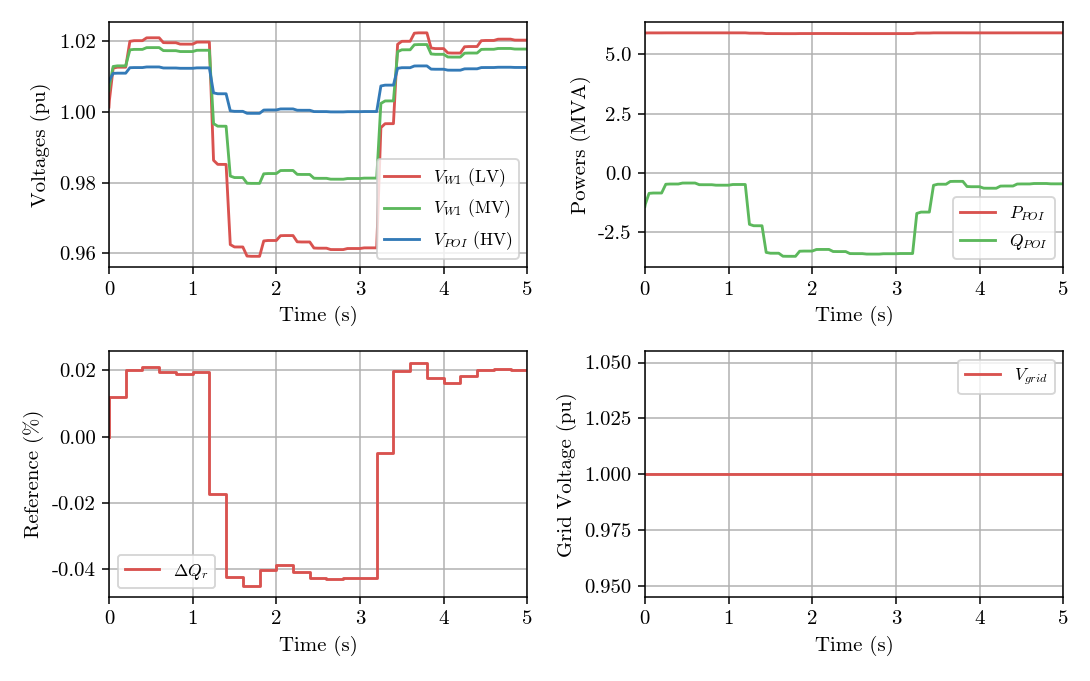

In [67]:
plt.close('all')
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(8, 5), frameon=False, dpi=100, squeeze=False)

v_POI_a = syst.get_values('v_POI_a_r') + 1j* syst.get_values('v_POI_a_i')
v_POI_a_m = np.abs(v_POI_a)/38105

axes[0,0].plot(syst.T, syst.get_values('v_m_W1lv'), label="$V_{W1}$ (LV)")
axes[0,0].plot(syst.T, syst.get_values('v_m_W1mv'), label="$V_{W1}$ (MV)")
axes[0,0].plot(syst.T, v_POI_a_m, label="$V_{POI}$ (HV)")

axes[0,1].plot(syst.T, get_flow(syst,'POI','GRID').real/1e6, label="$P_{POI}$")  
axes[0,1].plot(syst.T, get_flow(syst,'POI','GRID').imag/1e6, label="$Q_{POI}$")  

axes[1,0].step(Times, 100*np.array(Dq_r_list), label= "$\Delta Q_{r}$")

axes[1,1].step(Times,  np.array(U_grid), label= "$V_{grid}$")


y_labels = ['Voltages (pu)', 'Powers (MVA)', 'Reference (%)', 'Grid Voltage (pu)']
for ax,ylabel in zip(axes.flatten(),y_labels):
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.legend()
    ax.set_xlim([0,5])

    ax.set_xlabel('Time (s)')

fig.tight_layout()
fig.savefig('cctrl_ref.svg')
fig.savefig('cctrl_ref.png', dpi=200)

### Centralized control perturbation

In [68]:
syst = grid_wind_farm_class()
syst.Dt = 0.005
syst.xy_prev = xy_0
syst.update()
K_p_v = 0.01
PV_ctrl = 0
syst.initialization_tol = 1e-8
syst.initialize([{'v_loc_ref_W1lv':1.0,'v_loc_ref_W2lv':1.0,'v_loc_ref_W3lv':1.0,'v_loc_ref_STlv':1.0,
                  'Dv_r_W1lv':0.0,'Dv_r_W2lv':0.0,'Dv_r_W3lv':0.0,'Dv_r_STlv':0.0,
                  'Dq_r_W1lv':0.0,'Dq_r_W2lv':0.0,'Dq_r_W3lv':0.0,'Dq_r_STlv':0.0,
                  'K_p_v_W1lv':K_p_v,'K_p_v_W2lv':K_p_v,'K_p_v_W3lv':K_p_v,'K_p_v_STlv':0.0,
                  'u_ctrl_v_W1lv':PV_ctrl, 'u_ctrl_v_W2lv':PV_ctrl, 'u_ctrl_v_W3lv':PV_ctrl,'u_ctrl_v_STlv':0}],xy0='prev')


p_w1_0 = 2e6
p_w2_0 = 2e6
p_w3_0 = 2e6

p_w1_1 = 2e6
p_w2_1 = 2e6
p_w3_1 = 2e6




Dt = 0.2
Times = np.arange(0,6.0,Dt)
U_ref = 66.0e3
xi = 0

K_p = 0.01
K_i = 0.1
S_base = 1e6
U_base = 66e3

U_grid = []
U = []
Dq_r_list = []
t_0 = time.time()
Dv_r_prev = 0.0
Dq_r_prev = 0.0

for t in Times:
    
    Dv_r = Dv_r_prev
    Dq_r = Dq_r_prev
    
    # perturbations and events
    U_ref_pu = 1.0 
    if t >1.0:
        U_ref_pu = 1.0
    if t >3.0:
        U_ref_pu = 1.0 
    
    U_grid_pu = 1.0
    if t >2.0:
        U_grid_pu = 0.98
    if t >4.0:
        U_grid_pu = 1.0
    
    set_voltage(syst,'GRID',U_grid_pu*66e3,30)
    
    # measurments
    U_meas_pu = get_voltage(syst,'POI')/38105
    
    # PI control
    epsilon = U_ref_pu - U_meas_pu
    xi = xi + Dt*epsilon
    Dq_r_prev = K_p*epsilon + K_i*xi 
    Dv_r_prev = 0.0

    
    events = [{'t_end':t,
               'Dv_r_W1lv':Dv_r,'Dv_r_W2lv':Dv_r,'Dv_r_W3lv':Dv_r,
               'Dq_r_W1lv':Dq_r,'Dq_r_W2lv':Dq_r,'Dq_r_W3lv':Dq_r}]
    syst.run(events)
    
    U_grid += [U_grid_pu]
    U += [U_meas_pu]
    Dq_r_list += [Dq_r]
syst.post();    

print(time.time()-t_0)


0.5472867488861084


<IPython.core.display.Javascript object>


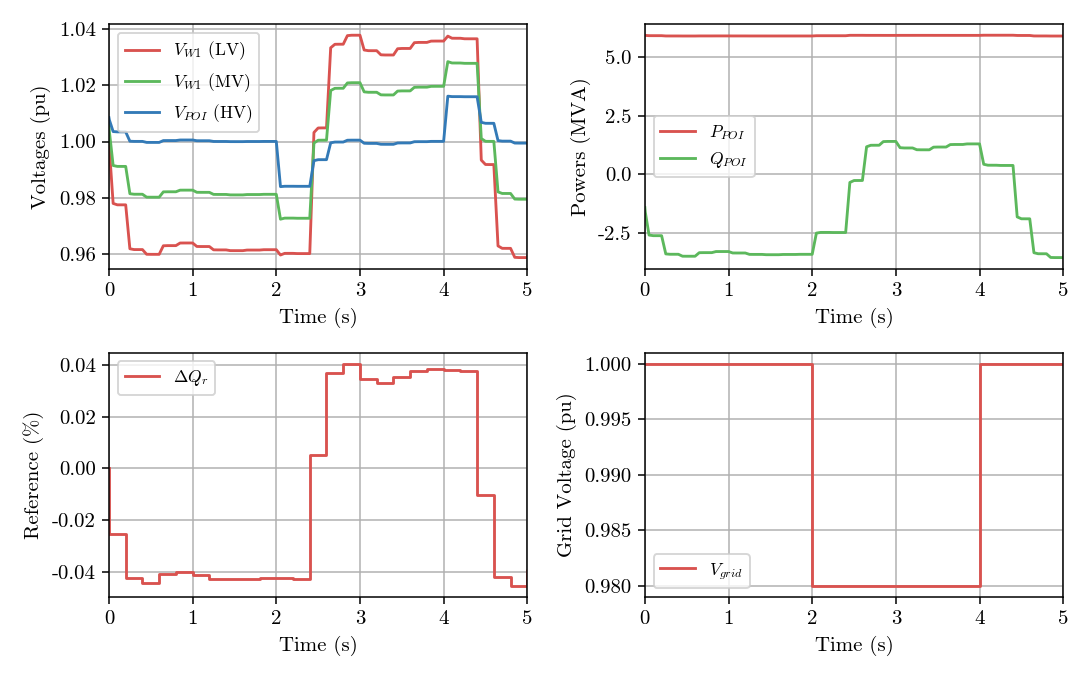

In [69]:
plt.close('all')
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(8, 5), frameon=False, dpi=100, squeeze=False)

v_POI_a = syst.get_values('v_POI_a_r') + 1j* syst.get_values('v_POI_a_i')
v_POI_a_m = np.abs(v_POI_a)/38105

axes[0,0].plot(syst.T, syst.get_values('v_m_W1lv'), label="$V_{W1}$ (LV)")
axes[0,0].plot(syst.T, syst.get_values('v_m_W1mv'), label="$V_{W1}$ (MV)")
axes[0,0].plot(syst.T, v_POI_a_m, label="$V_{POI}$ (HV)")

axes[0,1].plot(syst.T, get_flow(syst,'POI','GRID').real/1e6, label="$P_{POI}$")  
axes[0,1].plot(syst.T, get_flow(syst,'POI','GRID').imag/1e6, label="$Q_{POI}$")  

axes[1,0].step(Times, 100*np.array(Dq_r_list), label= "$\Delta Q_{r}$")

axes[1,1].step(Times,  np.array(U_grid), label= "$V_{grid}$")


y_labels = ['Voltages (pu)', 'Powers (MVA)', 'Reference (%)', 'Grid Voltage (pu)']
for ax,ylabel in zip(axes.flatten(),y_labels):
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.legend()
    ax.set_xlim([0,5])

    ax.set_xlabel('Time (s)')

fig.tight_layout()
fig.savefig('cctrl_ref.svg')
fig.savefig('cctrl_ref.png', dpi=200)

In [36]:
syst.report_y()

v_W1lv_a_r = -48.77
v_W1lv_a_i = 404.98
v_W1lv_b_r = -326.34
v_W1lv_b_i = -244.73
v_W1lv_c_r = 375.11
v_W1lv_c_i = -160.25
v_W2lv_a_r = -48.66
v_W2lv_a_i = 404.88
v_W2lv_b_r = -326.31
v_W2lv_b_i = -244.59
v_W2lv_c_r = 374.97
v_W2lv_c_i = -160.30
v_W3lv_a_r = -48.44
v_W3lv_a_i = 404.66
v_W3lv_b_r = -326.22
v_W3lv_b_i = -244.28
v_W3lv_c_r = 374.67
v_W3lv_c_i = -160.38
v_STlv_a_r = -29.17
v_STlv_a_i = 403.45
v_STlv_b_r = -334.81
v_STlv_b_i = -226.99
v_STlv_c_r = 363.98
v_STlv_c_i = -176.46
v_POI_a_r = 32900.38
v_POI_a_i = 20138.74
v_POI_b_r = -33890.85
v_POI_b_i = 18423.19
v_POI_c_r = 990.47
v_POI_c_i = -38561.94
v_POImv_a_r = 5114.90
v_POImv_a_i = 10550.27
v_POImv_b_r = -11694.25
v_POImv_b_i = -845.50
v_POImv_c_r = 6579.36
v_POImv_c_i = -9704.77
v_W1mv_a_r = 5107.31
v_W1mv_a_i = 10577.23
v_W1mv_b_r = -11713.80
v_W1mv_b_i = -865.56
v_W1mv_c_r = 6606.49
v_W1mv_c_i = -9711.67
v_W2mv_a_r = 5108.58
v_W2mv_a_i = 10572.74
v_W2mv_b_r = -11710.55
v_W2mv_b_i = -862.21
v_W2mv_c_r = 6601.97
v_W2mv_c

In [49]:
syst = grid_wind_farm_class()
syst.Dt = 0.005

K_p_v = 0.01
PV_ctrl = 1
syst.initialization_tol = 1e-8
Dq_r_0 = 0.0
Dv_r_0 = 0.0
for it in range(100):
    syst.xy_prev = xy_0
    syst.initialize([{'v_loc_ref_W1lv':1.0,'v_loc_ref_W2lv':1.0,'v_loc_ref_W3lv':1.0,'v_loc_ref_STlv':1.0,
                  'Dv_r_W1lv':Dv_r_0,'Dv_r_W2lv':Dv_r_0,'Dv_r_W3lv':Dv_r_0,'Dv_r_STlv':0.0,
                  'Dq_r_W1lv':0.0,'Dq_r_W2lv':0.0,'Dq_r_W3lv':0.0,'Dq_r_STlv':0.0,
                  'K_p_v_W1lv':K_p_v,'K_p_v_W2lv':K_p_v,'K_p_v_W3lv':K_p_v,'K_p_v_STlv':0.0,
                  'u_ctrl_v_W1lv':PV_ctrl, 'u_ctrl_v_W2lv':PV_ctrl, 'u_ctrl_v_W3lv':PV_ctrl,'u_ctrl_v_STlv':0}],xy0='prev')
    U_meas_pu = get_voltage(syst,'POI')/38105
    Dv_r_0 = Dv_r_0 + 1.0*(  (1-U_meas_pu) )
    #print(Dv_r_0,U_meas_pu)

p_w1_0 = 2e6
p_w2_0 = 2e6
p_w3_0 = 2e6

p_w1_1 = 2e6
p_w2_1 = 2e6
p_w3_1 = 2e6


Dt = 0.2
Times = np.arange(0,5.0,Dt)
U_ref = 66.0e3
xi = 0.0

K_p = 1.0
K_i = 5.1
S_base = 1e6
U_base = 66e3

U = []
Dv_r_list = []
Dv_r_prev = Dv_r_0
Dq_r_prev = Dq_r_0

for t in Times:
    
    Dv_r = Dv_r_prev
    Dq_r = Dq_r_prev
    
    # perturbations and events
    U_ref_pu = 1.0 
    if t >1.0:
        U_ref_pu = 1.05
    if t >3.0:
        U_ref_pu = 1.0 
    
    U_grid_pu = 1.0
    if t >2.0:
        U_grid_pu = 1.0
    if t >4.0:
        U_grid_pu = 1.0
    
    set_voltage(syst,'GRID',U_grid_pu*66e3,30)
    
    # measurments
    U_meas_pu = get_voltage(syst,'POI')/38105
    
    # PI control
    epsilon = U_ref_pu - U_meas_pu
    xi = xi + Dt*epsilon
    Dv_r_prev = K_p*epsilon + K_i*xi   
    Dq_r_prev = 0.0

    
    events = [{'t_end':t,
               'Dv_r_W1lv':Dv_r+Dv_r_0,'Dv_r_W2lv':Dv_r+Dv_r_0,'Dv_r_W3lv':Dv_r+Dv_r_0,
               'Dq_r_W1lv':Dq_r,'Dq_r_W2lv':Dq_r,'Dq_r_W3lv':Dq_r}]
    syst.run(events)
    
    U += [U_meas_pu]
    Dv_r_list += [Dv_r]
syst.post();    

In [50]:
plt.close('all')
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 5), frameon=False, dpi=80)


v_POI_a = syst.get_values('v_POI_a_r') + 1j* syst.get_values('v_POI_a_i')
v_POI_a_m = np.abs(v_POI_a)/38105


axes[0,0].plot(syst.T, syst.get_values('v_m_W1lv'), label="$V_{W1}$ (LV)")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W2lv'), label=f"W2")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W3lv'), label=f"W3")
axes[0,0].plot(syst.T, syst.get_values('v_m_W1mv'), label="$V_{W1}$ (MV)")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W2mv'), label=f"W2mv")
#axes[0,0].plot(syst.T, syst.get_values('v_m_W3mv'), label=f"W3mv")
axes[0,0].plot(syst.T, v_POI_a_m, label="$V_{POI}$ (HV)")


axes[1,0].step(Times, Dv_r_list, label=f"Dv_r")

axes[1,1].plot(syst.T, get_flow(syst,'POI','GRID').imag/1e6, label="$Q_{POI}$")  

for ax in axes.flatten():
    ax.grid()
    ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No handles with labels found to put in legend.


In [78]:
Dv_r_0

-0.07158693291818197

In [18]:
params = np.array(syst.params_values_list)
u = np.array(syst.u_ini_values_list)
x = syst.struct[0].x
y = syst.struct[0].y_ini
y_ini = syst.struct[0].y_ini
Fx = syst.struct[0].Fx_ini
Fy = syst.struct[0].Fy_ini
Gx = syst.struct[0].Gx_ini
Gy = syst.struct[0].Gy_ini
Fu = syst.struct[0].Fu
Gu = syst.struct[0].Gu
Hx = syst.struct[0].Hx
Hy = syst.struct[0].Hy
Hu = syst.struct[0].Hu
f = syst.struct[0].f
g = syst.struct[0].g

In [19]:
syst.report_u()

v_GRID_a_r = 33000.00
v_GRID_a_i = 19052.56
v_GRID_b_r = -33000.00
v_GRID_b_i = 19052.56
v_GRID_c_r =  0.00
v_GRID_c_i = -38105.12
i_POI_a_r =  0.00
i_POI_a_i =  0.00
i_POI_b_r =  0.00
i_POI_b_i =  0.00
i_POI_c_r =  0.00
i_POI_c_i =  0.00
i_POImv_a_r =  0.00
i_POImv_a_i =  0.00
i_POImv_b_r =  0.00
i_POImv_b_i =  0.00
i_POImv_c_r =  0.00
i_POImv_c_i =  0.00
i_W1mv_a_r =  0.00
i_W1mv_a_i =  0.00
i_W1mv_b_r =  0.00
i_W1mv_b_i =  0.00
i_W1mv_c_r =  0.00
i_W1mv_c_i =  0.00
i_W2mv_a_r =  0.00
i_W2mv_a_i =  0.00
i_W2mv_b_r =  0.00
i_W2mv_b_i =  0.00
i_W2mv_c_r =  0.00
i_W2mv_c_i =  0.00
i_W3mv_a_r =  0.00
i_W3mv_a_i =  0.00
i_W3mv_b_r =  0.00
i_W3mv_b_i =  0.00
i_W3mv_c_r =  0.00
i_W3mv_c_i =  0.00
i_STmv_a_r = -0.00
i_STmv_a_i =  0.00
i_STmv_b_r =  0.00
i_STmv_b_i =  0.00
i_STmv_c_r =  0.00
i_STmv_c_i =  0.00
p_ref_W1lv = 2000000.00
T_pq_W1lv =  0.20
v_loc_ref_W1lv =  1.00
Dv_r_W1lv =  0.02
Dq_r_W1lv =  0.00
p_ref_W2lv = 2000000.00
T_pq_W2lv =  0.20
v_loc_ref_W2lv =  1.00
Dv_r_W2lv =  0.02
D